In [1]:
# import all we need
from matplotlib import image
from matplotlib import pyplot
import time
import os
import numpy as np
import glob
import shutil
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pylab as plt
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras import layers
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)
import sklearn
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score
import pandas as pd 
import cv2
from tqdm import tqdm
from imblearn.over_sampling import SMOTE, ADASYN
from tensorflow.keras import datasets, layers, models, losses, Model
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns
from tensorflow.keras.regularizers import l2

In [2]:
# set up dir of data
base_dir = '../plant-seedlings-classification/data'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
# the 12 species
classes = os.listdir(train_dir)
# parameter
batch_size = 32
IMG_SHAPE = 150

In [3]:
#read training set
for dirname, _, filenames in os.walk(train_dir):
    for filename in filenames:
        os.path.join(dirname, filename)

DATADIR = train_dir
classes = os.listdir(train_dir)
IMG_SIZE= IMG_SHAPE
CATEGORIES = classes

training_data=[]
def create_training_data():
    for category in CATEGORIES:
        path=os.path.join(DATADIR, category)
        class_num=CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array=cv2.imread(os.path.join(path,img))
                new_array=cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
                training_data.append([new_array,class_num])
            except Exception as e:
                pass
create_training_data()
X=[]
y=[]

for categories, label in training_data:
    y.append(label)
    X.append(categories)

In [4]:
#read val set
for dirname, _, filenames in os.walk(val_dir):
    for filename in filenames:
        os.path.join(dirname, filename)

DATADIR = val_dir
classes = os.listdir(val_dir)
IMG_SIZE= IMG_SHAPE
CATEGORIES = classes

val_data=[]
def create_val_data():
    for category in CATEGORIES:
        path=os.path.join(DATADIR, category)
        class_num=CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array=cv2.imread(os.path.join(path,img))
                new_array=cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
                val_data.append([new_array,class_num])
            except Exception as e:
                pass
create_val_data()
X_val=[]
y_val=[]

for categories, label in val_data:
    y_val.append(label)
    X_val.append(categories)


In [5]:
X=np.array(X)
y=np.array(y)
X_val=np.array(X_val)
y_val=np.array(y_val)

In [6]:
datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )
# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(X)
# fits the model on batches with real-time data augmentation:
train_data_gen = datagen.flow(X, 
                              y,
                              shuffle=True,
                              batch_size=batch_size)

In [7]:
image_gen_val = ImageDataGenerator(rescale=1./255)
image_gen_val.fit(X_val)
val_data_gen = image_gen_val.flow(X_val,
                                  y_val,
                                  batch_size=batch_size)

In [8]:
# model
model = Sequential()

model.add(Conv2D(16, (3,3), padding='same',strides=2, activation='relu', input_shape=(IMG_SHAPE,IMG_SHAPE, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dense(12, kernel_regularizer=tf.keras.regularizers.l2(0.01),activation
             ='linear'))

In [9]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 75, 75, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 37, 37, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 37, 37, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 18, 18, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 18, 18, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 9, 9, 64)         0

In [11]:
epochs = 120

history = model.fit(
    train_data_gen,
    steps_per_epoch=int(np.ceil(train_data_gen.n / float(batch_size))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(val_data_gen.n / float(batch_size)))
)

Epoch 1/120
119/119 [==============================] - 29s 230ms/step - loss: 2.4052 - accuracy: 0.1886 - val_loss: 1.9168 - val_accuracy: 0.3288
Epoch 2/120
119/119 [==============================] - 28s 231ms/step - loss: 1.8618 - accuracy: 0.3528 - val_loss: 1.5541 - val_accuracy: 0.4773
Epoch 3/120
119/119 [==============================] - 28s 235ms/step - loss: 1.6243 - accuracy: 0.4336 - val_loss: 1.5082 - val_accuracy: 0.4700
Epoch 4/120
119/119 [==============================] - 29s 243ms/step - loss: 1.4845 - accuracy: 0.4865 - val_loss: 1.5536 - val_accuracy: 0.4531
Epoch 5/120
119/119 [==============================] - 30s 248ms/step - loss: 1.4086 - accuracy: 0.5222 - val_loss: 1.1640 - val_accuracy: 0.6217
Epoch 6/120
119/119 [==============================] - 28s 237ms/step - loss: 1.3593 - accuracy: 0.5346 - val_loss: 1.0603 - val_accuracy: 0.6396
Epoch 7/120
119/119 [==============================] - 29s 246ms/step - loss: 1.2819 - accuracy: 0.5649 - val_loss: 0.9504 -

Epoch 57/120
119/119 [==============================] - 32s 267ms/step - loss: 0.4148 - accuracy: 0.8706 - val_loss: 0.3544 - val_accuracy: 0.8915
Epoch 58/120
119/119 [==============================] - 32s 268ms/step - loss: 0.4242 - accuracy: 0.8656 - val_loss: 0.2859 - val_accuracy: 0.9073
Epoch 59/120
119/119 [==============================] - 32s 270ms/step - loss: 0.4262 - accuracy: 0.8706 - val_loss: 0.2957 - val_accuracy: 0.9052
Epoch 60/120
119/119 [==============================] - 34s 286ms/step - loss: 0.4241 - accuracy: 0.8627 - val_loss: 0.3398 - val_accuracy: 0.8799
Epoch 61/120
119/119 [==============================] - 32s 267ms/step - loss: 0.4062 - accuracy: 0.8690 - val_loss: 0.4147 - val_accuracy: 0.8662
Epoch 62/120
119/119 [==============================] - 34s 285ms/step - loss: 0.4101 - accuracy: 0.8677 - val_loss: 0.2849 - val_accuracy: 0.9168
Epoch 63/120
119/119 [==============================] - 34s 283ms/step - loss: 0.3992 - accuracy: 0.8742 - val_loss: 0

119/119 [==============================] - 32s 271ms/step - loss: 0.2820 - accuracy: 0.9074 - val_loss: 0.3044 - val_accuracy: 0.9157
Epoch 113/120
119/119 [==============================] - 33s 277ms/step - loss: 0.3100 - accuracy: 0.9034 - val_loss: 0.3300 - val_accuracy: 0.8820
Epoch 114/120
119/119 [==============================] - 33s 278ms/step - loss: 0.2952 - accuracy: 0.9079 - val_loss: 0.2698 - val_accuracy: 0.9199
Epoch 115/120
119/119 [==============================] - 35s 290ms/step - loss: 0.2957 - accuracy: 0.9003 - val_loss: 0.2889 - val_accuracy: 0.9125
Epoch 116/120
119/119 [==============================] - 36s 301ms/step - loss: 0.2747 - accuracy: 0.9132 - val_loss: 0.2660 - val_accuracy: 0.9157
Epoch 117/120
119/119 [==============================] - 33s 275ms/step - loss: 0.2873 - accuracy: 0.9082 - val_loss: 0.2182 - val_accuracy: 0.9336
Epoch 118/120
119/119 [==============================] - 35s 290ms/step - loss: 0.2840 - accuracy: 0.9129 - val_loss: 0.2952 -

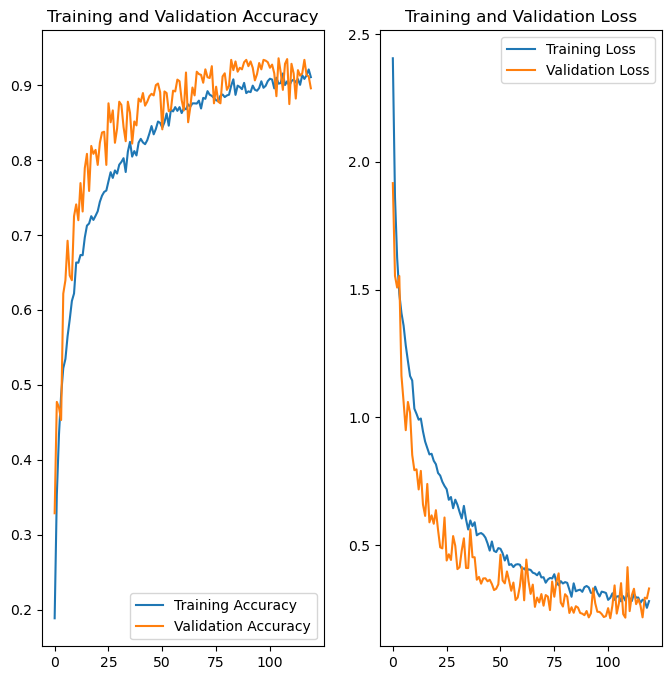

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [13]:
t = time.time()

export_path_keras = "./M1_1/{}.h5".format(int(t))
print(export_path_keras)

model.save(export_path_keras)

./M1_1/1672658570.h5


In [14]:
# reload
reloaded = tf.keras.models.load_model(
  './M1_1/1672658570.h5', 
  # `custom_objects` tells keras how to load a `hub.KerasLayer`
  custom_objects={'KerasLayer': hub.KerasLayer})

In [15]:
# predict the testdata
test_dir = '../plant-seedlings-classification/test'
testdata_dir = test_dir + '/testdata'
le = LabelEncoder()
le.fit(os.listdir(train_dir))
testdata = os.listdir(testdata_dir)
test_tal_num = 0
im = []
allimages= []
img_path = os.path.join(test_dir, 'testdata')
images = glob.glob(img_path + '/*.png')
allimages.extend(images)
#print("{}: {} Images".format(cl, len(images)))
test_tal_num += len(images)
#num_train = int(round(len(images)*0.8))
#train, val = images[:num_train], images[num_train:]
for i in range(len(images)):
    img = cv2.imread(allimages[i])
    img = tf.image.resize(img, [150,150])
    im.append(img)
im = np.array(im)/255.0
predictions = reloaded.predict(im)

25/25 [==============================] - 1s 23ms/step


In [16]:
results = []
for i in range(predictions.shape[0]):
    results.append(np.argmax(predictions[i]))
PredStr = list(le.inverse_transform(results))
result = {'file':testdata,'species':PredStr}
result = pd.DataFrame(result)
result.to_csv("Prediction_M1_1.csv",index=False)
#score : 0.94

30/30 [==============================] - 1s 21ms/step


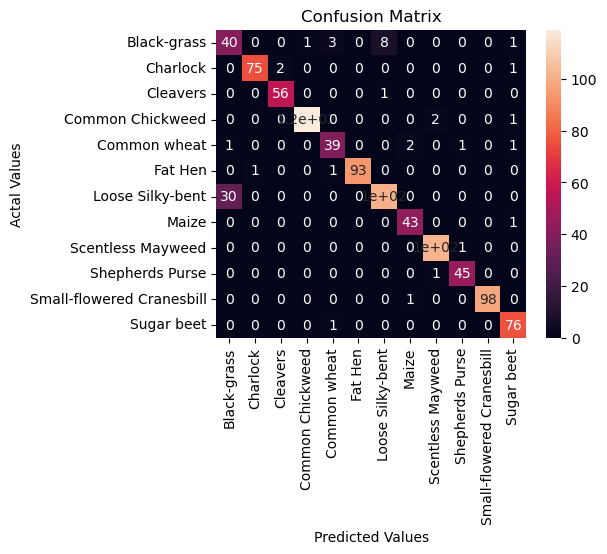

In [18]:
# confution matrix
X_val = X_val/255
prediction_val = reloaded.predict(X_val)
results_val = []
for i in range(prediction_val.shape[0]):
    results_val.append(np.argmax(prediction_val[i]))
# Creating  a confusion matrix,which compares the y_test and y_pred
cm = confusion_matrix(y_val, results_val)
cm_df = pd.DataFrame(cm,
                     index = classes, 
                     columns = classes)
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()